In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = 'cuda'

In [3]:
import os

# Get the directory path
directory_path = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/images"

# Count the number of files in the directory
num_files = len(os.listdir(directory_path))

# Print the number of files
print(f"Number of files in the directory: {num_files}")

Number of files in the directory: 291


In [4]:
def get_data(path):
    categories = ['COVID-19', 'Non-COVID', 'Normal']
    data = []
    for category in categories:
        path_curr = path + f'{category}/images/'
        data_list = os.listdir(path_curr)
        for filename in data_list:
            data_curr = {}
            filepath_image = os.path.join(path_curr, filename)
            filepath_infection_mask = path + f'{category}/infection masks/{filename}'
            filepath_lung_mask = path + f'{category}/lung masks/{filename}'
            data_curr['image'] = filepath_image
            data_curr['infection_mask'] = filepath_infection_mask
            data_curr['lung_mask'] = filepath_lung_mask
            data_curr['category'] = category
            data.append(data_curr)
    return data

In [5]:
train_set = get_data('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/')
print(f'Train set length: {len(train_set)}')
valid_set = get_data('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/')
print(f'Valid set length: {len(valid_set)}')
test_set = get_data('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/')
print(f'Test set length: {len(test_set)}')

Train set length: 3728
Valid set length: 932
Test set length: 1166


255


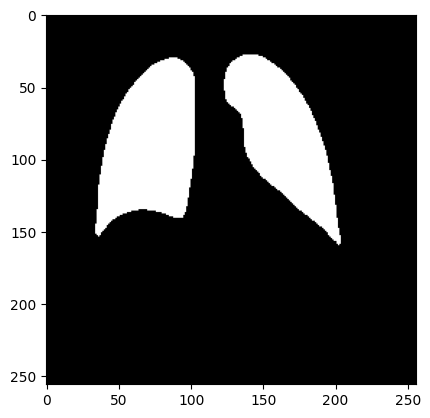

In [6]:
test = cv.imread('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/lung masks/covid_100.png')
plt.imshow(test)
print(np.max(test))

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [8]:
mms = MinMaxScaler()

In [14]:
class CustomDataset(Dataset):
    def __init__(self, data, transform, scaler):
        self.data = data
        self.transform = transform
        self.scaler = scaler
    def __getitem__(self, index):
        lung_mask_path = self.data[index]['lung_mask']
        image_path = self.data[index]['image']
        image = np.array(cv.imread(image_path))[:,:,0]
        lung_mask = np.array(cv.imread(lung_mask_path))[:,:,0]
        X = self.transform(image)
        X = self.scaler.fit_transform(X[0])
        X = np.expand_dims(X, 0)
        X = torch.FloatTensor(X)
        
        infection_mask_path = self.data[index]['infection_mask']
        infection_mask = np.array(cv.imread(infection_mask_path))[:,:,0]
        all_mask = np.zeros_like(infection_mask)
        all_mask[np.where(lung_mask == 255)] = 125
        all_mask[np.where(infection_mask == 255)] = 255
        y = self.transform(all_mask)
        return X, y
    def __len__(self):
        return len(self.data)

In [10]:
#No lung mask
class CustomDataset(Dataset):
    def __init__(self, data, transform, scaler):
        self.data = data
        self.transform = transform
        self.scaler = scaler
    def __getitem__(self, index):
        image_path = self.data[index]['image']
        image = np.array(cv.imread(image_path))[:,:,0]
        X = self.transform(image)
        X = self.scaler.fit_transform(X[0])
        X = np.expand_dims(X, 0)
        X = torch.FloatTensor(X)
        
        infection_mask_path = self.data[index]['infection_mask']
        infection_mask = np.array(cv.imread(infection_mask_path))[:,:,0]
        all_mask = np.zeros_like(infection_mask)
        all_mask[np.where(infection_mask == 255)] = 255
        y = self.transform(all_mask)
        return X, y
    def __len__(self):
        return len(self.data)

In [15]:
train_cd = CustomDataset(train_set, transform, mms)
train_loader = DataLoader(train_cd, batch_size = 16, shuffle = True)
valid_cd = CustomDataset(valid_set, transform, mms)
valid_loader = DataLoader(valid_cd, batch_size = 8, shuffle = False)
test_cd = CustomDataset(test_set, transform, mms)
test_loader = DataLoader(test_cd, batch_size = 1, shuffle = False)

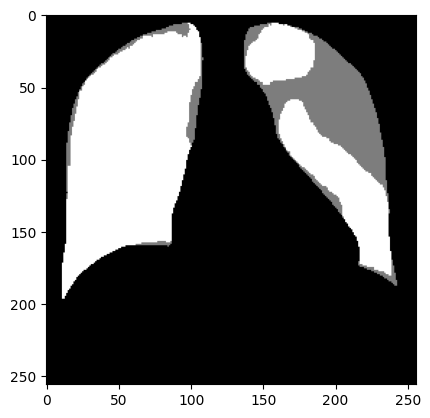

In [16]:
plt.imshow(train_cd[100][1].squeeze(0), cmap = 'gray')

In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.conv3x3_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.conv3x3_5 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2,stride=2),
            nn.Dropout(0.2)
        )
        self.conv3x3_6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2,stride=2),
            nn.Dropout(0.2)
        )
        self.conv3x3_7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.conv3x3_8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )
        self.upconv2x2_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.conv3x3_9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

#     def crop(self, x, out_shape):
#         in_shape = x.shape[-1]
#         out = x[:,:,(in_shape-out_shape)//2:(in_shape-out_shape)//2+out_shape,(in_shape-out_shape)//2:(in_shape-out_shape)//2+out_shape]
#         return(out)
    def forward(self, x):
        cv1 = self.conv3x3_1(x)
#         print(f"Cv1: {cv1.size()}")
#         crop_cv1 = self.crop(cv1, 392)

        cv2 = self.conv3x3_2(cv1)
#         print(f"Cv2: {cv2.size()}")
#         crop_cv2 = self.crop(cv2, 200)

        cv3 = self.conv3x3_3(cv2)
#         print(f"Cv3: {cv3.size()}")
#         crop_cv3 = self.crop(cv3, 104)

        cv4 = self.conv3x3_4(cv3)
#         print(f"Cv4: {cv4.size()}")
#         crop_cv4 = self.crop(cv4, 56)

        cv5 = self.conv3x3_5(cv4)
#         print(f"Cv5: {cv5.size()}")

        upcv1 = self.upconv2x2_1(cv5)
#         print(f"UpCv1: {upcv1.size()}         CropCv4: {cv4.size()}")
        
        cv6 = self.conv3x3_6(torch.cat([cv4, upcv1], dim = 1))
#         print(f"Cv6: {cv6.size()}")

        upcv2 = self.upconv2x2_2(cv6)
#         print(f"UpCv2: {upcv2.size()}         CropCv3: {cv3.size()}")
        cv7 = self.conv3x3_7(torch.cat([cv3, upcv2], dim = 1))

        upcv3 = self.upconv2x2_3(cv7)
#         print(f"UpCv3: {upcv3.size()}         CropCv2: {cv2.size()}")
        cv8 = self.conv3x3_8(torch.cat([cv2, upcv3], dim = 1))

        upcv4 = self.upconv2x2_4(cv8)
#         print(f"UpCv4: {upcv4.size()}         CropCv1: {cv1.size()}")
        cv9 = self.conv3x3_9(torch.cat([cv1, upcv4], dim = 1))

        out = self.output(cv9)

        return out


In [18]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    losses = np.array([])
    for X, y in tqdm(dataloader):
        # Compute prediction error
        pred = model(X.to(device))
        # class_pred = torch.argmax(pred, dim = -1)
        loss = loss_fn(pred, y.to(device))
#         print(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses = np.append(losses, loss.item())

    loss_mean = losses.mean()
    print(f"loss mean per batch: {loss_mean:.20f}")
    return loss_mean

In [19]:
def validating(dataloader, model, loss_fn):

    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss per batch: {test_loss:.20f} \n")
    return test_loss

In [20]:
model = Model().to(device)
criterion = nn.BCELoss()
optimizer =  torch.optim.Adam(model.parameters(),
                          lr=0.0008, weight_decay = 0.00000001, foreach=True)

In [148]:
train_losses = []
val_losses = []

In [149]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(train_loader, model, criterion, optimizer))
    val_losses.append(validating(valid_loader, model, criterion))
    if (t+1) % 10 == 0:
        torch.save(model.state_dict(), f"/kaggle/working/model_{t+1}_2masks.pt")
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 233/233 [01:59<00:00,  1.94it/s]


loss mean per batch: 0.65727615868073163696
Test Error: 
 Avg loss per batch: 1.02584055397245621499 

Epoch 2
-------------------------------


100%|██████████| 233/233 [01:53<00:00,  2.05it/s]


loss mean per batch: 0.56999056162752304022
Test Error: 
 Avg loss per batch: 0.47587363893150264049 

Epoch 3
-------------------------------


100%|██████████| 233/233 [01:53<00:00,  2.06it/s]


loss mean per batch: 0.51474119844354782050
Test Error: 
 Avg loss per batch: 0.62865141696400117510 

Epoch 4
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.46710460533911579706
Test Error: 
 Avg loss per batch: 0.43068393351685285708 

Epoch 5
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.42804524980389507816
Test Error: 
 Avg loss per batch: 0.62139303434608328391 

Epoch 6
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.39009188390596744034
Test Error: 
 Avg loss per batch: 0.34331485297944808188 

Epoch 7
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.36131316090858034418
Test Error: 
 Avg loss per batch: 0.45833627102721452573 

Epoch 8
-------------------------------


100%|██████████| 233/233 [01:53<00:00,  2.05it/s]


loss mean per batch: 0.33320009977009162894
Test Error: 
 Avg loss per batch: 0.44483889728529840690 

Epoch 9
-------------------------------


100%|██████████| 233/233 [01:53<00:00,  2.06it/s]


loss mean per batch: 0.30741039890588095496
Test Error: 
 Avg loss per batch: 0.33424788662511056847 

Epoch 10
-------------------------------


100%|██████████| 233/233 [01:53<00:00,  2.06it/s]


loss mean per batch: 0.28318196144994234320
Test Error: 
 Avg loss per batch: 0.27606338784735429126 

Epoch 11
-------------------------------


100%|██████████| 233/233 [01:53<00:00,  2.06it/s]


loss mean per batch: 0.26566823344885537317
Test Error: 
 Avg loss per batch: 0.29086231586770117108 

Epoch 12
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.06it/s]


loss mean per batch: 0.24842183707609707954
Test Error: 
 Avg loss per batch: 0.21791304087536966794 

Epoch 13
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.23110545001316479263
Test Error: 
 Avg loss per batch: 0.20883148068036788692 

Epoch 14
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.06it/s]


loss mean per batch: 0.21293060679804101665
Test Error: 
 Avg loss per batch: 0.20077469766649425065 

Epoch 15
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.20137048995546005803
Test Error: 
 Avg loss per batch: 0.19598340402301558938 

Epoch 16
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.06it/s]


loss mean per batch: 0.19330058019816107051
Test Error: 
 Avg loss per batch: 0.17998326735364067464 

Epoch 17
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.06it/s]


loss mean per batch: 0.17264678709752570573
Test Error: 
 Avg loss per batch: 0.17366017216545903690 

Epoch 18
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.06it/s]


loss mean per batch: 0.16085465642515681117
Test Error: 
 Avg loss per batch: 0.16623279248547351283 

Epoch 19
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.15269187255862445851
Test Error: 
 Avg loss per batch: 0.18703047294392544098 

Epoch 20
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.14426900222577762611
Test Error: 
 Avg loss per batch: 0.14755804333676639239 

Epoch 21
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.13473719962804614481
Test Error: 
 Avg loss per batch: 0.13392253462065997760 

Epoch 22
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.12504186404493233820
Test Error: 
 Avg loss per batch: 0.12730066809389325999 

Epoch 23
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.12093886969682995924
Test Error: 
 Avg loss per batch: 0.13028313977341365870 

Epoch 24
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.08it/s]


loss mean per batch: 0.11225758873469840471
Test Error: 
 Avg loss per batch: 0.17576726729798519688 

Epoch 25
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.10409711362082559039
Test Error: 
 Avg loss per batch: 0.12547315816339263406 

Epoch 26
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.10141253698409370687
Test Error: 
 Avg loss per batch: 0.12049733761411446364 

Epoch 27
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.09553577440746864602
Test Error: 
 Avg loss per batch: 0.11322066461683338856 

Epoch 28
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.08542603347050785334
Test Error: 
 Avg loss per batch: 0.10146141351542921349 

Epoch 29
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.08503812919230931133
Test Error: 
 Avg loss per batch: 0.10414963896967406598 

Epoch 30
-------------------------------


100%|██████████| 233/233 [01:52<00:00,  2.07it/s]


loss mean per batch: 0.07786668333436798373
Test Error: 
 Avg loss per batch: 0.11365624205169515271 

Done!


In [21]:
print(train_losses)


[0.55549568 0.48472445 0.43959463 0.40482788 0.37680698 0.35199229
 0.32901018 0.31139206 0.29436561 0.27977803 0.26842503 0.25479431
 0.24413498 0.23426847 0.22594081 0.21809788 0.20899742 0.20469718
 0.20045934 0.19241607 0.19027326 0.18480799 0.17903163 0.17645135
 0.17328751 0.17020889 0.16638762 0.16740306 0.16192675 0.15854991
 0.15812353 0.1569448  0.15358752 0.15218215 0.15010656 0.14829006
 0.14743512 0.14704549 0.14466286 0.14409372 0.14655819 0.16015124
 0.14448839 0.14148809 0.1401005  0.1389232  0.13831627 0.13794314
 0.13825943 0.13686487]


In [22]:
print(val_losses)

[0.47704366 0.45430734 0.49799438 0.40381165 0.46026676 0.36945506
 0.32040481 0.39970513 0.29422733 0.26099065 0.25916062 0.24784958
 0.23174373 0.22604908 0.2176225  0.21021067 0.22447536 0.20624194
 0.20098044 0.1956941  0.19196227 0.18747775 0.18163237 0.18969698
 0.18262523 0.17464685 0.17687628 0.17093179 0.16926695 0.16639316
 0.21571116 0.16797436 0.16645713 0.16551957 0.16191489 0.16126094
 0.15924407 0.16665369 0.15932447 0.15884112 0.21010956 0.15882191
 0.15980291 0.15604959 0.15814724 0.15694059 0.15605637 0.15878915
 0.15890383 0.15545363]


In [11]:
train_losses = np.array([0.5554956804017652, 0.4847244542299934, 0.4395946335894867, 0.40482788254774693, 0.37680698259705636, 0.3519922856865011, 0.3290101756609561, 0.31139205517687, 0.2943656137572849, 0.27977803330308887, 0.2684250321766849, 0.2547943138641349, 0.24413497835525627, 0.23426846904048593, 0.22594080750266882, 0.2180978834245338, 0.20899742202185767, 0.2046971808431486, 0.20045934393682194, 0.19241607233945904, 0.19027326233653039, 0.1848079865966232, 0.17903162724470376, 0.17645134575377205, 0.17328751119165461, 0.17020889080645188, 0.16638762180897299, 0.16740305862457455, 0.16192674620852449, 0.15854990523900087, 0.15812352900852972, 0.15694479935286895, 0.15358751714869118, 0.15218214581964354, 0.15010655636183692, 0.14829006225126495, 0.1474351174329995, 0.14704548944859033, 0.14466285667194317, 0.14409372194514253, 0.1465581883496481, 0.16015124148309487, 0.14448839035924413, 0.14148809290750855, 0.14010049677713746, 0.13892320492364818, 0.13831626860496823, 0.13794313585425652, 0.1382594337535007, 0.13686486854829502])
val_losses = np.array([0.4770436602779943, 0.4543073388755831, 0.4979943808836815, 0.4038116537098192, 0.4602667635832077, 0.3694550647185399, 0.3204048105284699, 0.39970513350433773, 0.2942273330229979, 0.260990650098548, 0.25916062486477387, 0.24784957853137937, 0.23174372621071646, 0.2260490788353814, 0.2176224999448173, 0.21021067395678952, 0.2244753582864745, 0.20624194058597597, 0.20098044271143073, 0.19569409543123, 0.19196226849005774, 0.18747775021017107, 0.18163237185814443, 0.18969698352182013, 0.18262523049727464, 0.1746468516623872, 0.17687628450047257, 0.17093179152052626, 0.1692669479510723, 0.16639315515247166, 0.21571115595407975, 0.16797436302543706, 0.16645713379749885, 0.16551956980146915, 0.16191488644506177, 0.16126093625003457, 0.1592440701957442, 0.16665369119399634, 0.1593244736138572, 0.15884111611506876, 0.2101095567146937, 0.1588219141221454, 0.15980291029072216, 0.15604959008021232, 0.158147238385983, 0.15694059437920904, 0.15605636870759165, 0.15878915016213033, 0.15890383433837157, 0.15545362718084937])

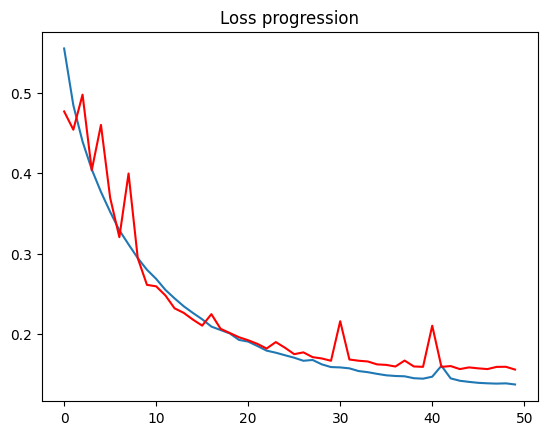

In [23]:
plt.plot(np.arange(0, 50), train_losses)
plt.plot(np.arange(0, 50), val_losses, c = 'red')
plt.title('Loss progression')
plt.show()

In [24]:
torch.save(model.state_dict(), "/kaggle/working/model.pt")

In [26]:
from pathlib import Path
model = Model().to(device)
# checkpoint = torch.load(Path('/kaggle/working/model_50.pt'))
model.load_state_dict(torch.load('/kaggle/working/model_50.pt'))
# model.load_state_dict(checkpoint)
model.eval()
# model = model.to(device)

Model(
  (conv3x3_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3x3_2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
  )
  (conv3x3_3): Sequential(
    (0): MaxPool2

In [94]:
train_loader_eval = DataLoader(train_cd, batch_size = 1, shuffle = False)
valid_loader_eval = DataLoader(valid_cd, batch_size = 1, shuffle = False)
test_loader_eval = DataLoader(test_cd, batch_size = 1, shuffle = False)

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def testing(dataloader, model, option):
    num_batches = len(dataloader)
    print(num_batches)
    model.eval()
    test_loss = 0
    e = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            test_1 = X.squeeze(0)
            pred_1 = model(test_1.unsqueeze(0)).detach().cpu().numpy().squeeze(0).squeeze(0)
            y_1 = y.detach().cpu().numpy().squeeze(0).squeeze(0)
            if option == 'mse':
                error = mean_squared_error(y_1, pred_1)
            elif option == 'mae':
                error = mean_absolute_error(y_1, pred_1)
            e += error
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_e = e / num_batches
    return avg_e
    

In [109]:
mse = testing(valid_loader_eval, model, 'mse')
print(mse)

932


100%|██████████| 932/932 [00:19<00:00, 48.93it/s]

0.008295745656477355


In [99]:
mae = testing(valid_loader_eval, model, 'mae')
print(mae)

932


100%|██████████| 932/932 [00:18<00:00, 49.18it/s]

0.024378951577981336


In [156]:
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score
def testing_postprocess(dataloader, model, option):
    num_batches = len(dataloader)
    print(num_batches)
    model.eval()
    scores = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            test_1 = X.squeeze(0)
            pred_1 = model(test_1.unsqueeze(0)).detach().cpu().numpy().squeeze(0).squeeze(0)
            pred_1[pred_1 < 0.24] = 0
            pred_1[pred_1 >= 0.74] = 2
            pred_1[(pred_1 >= 0.24) & (pred_1 < 0.74)] = 1
            
            y_1 = y.detach().cpu().numpy().squeeze(0).squeeze(0)
            y_1[y_1 == 0] = 0
            y_1[y_1 == 1] = 2
            y_1[(y_1 >= 0.48) & (y_1 < 0.5)] = 1
            
            if option == 'precision':
                score = precision_score(y_1.flatten(), pred_1.flatten(), average = 'macro')
            elif option == 'recall':
                score = recall_score(y_1.flatten().astype(np.int32), pred_1.flatten().astype(np.int32), average = 'macro')
            elif option =='f1':
                score = f1_score(y_1.flatten(), pred_1.flatten(), average = 'micro')
            elif option =='jaccard':
                score = jaccard_score(y_1.flatten(), pred_1.flatten(), average = 'micro')
            scores += score
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_score = scores / num_batches
    return avg_score

In [163]:
precision = testing_postprocess(train_loader_eval, model, 'jaccard')
print(precision)

3728


100%|██████████| 3728/3728 [02:55<00:00, 21.25it/s]

0.9731023253697246


In [ ]:
0.8863

torch.Size([256, 256])


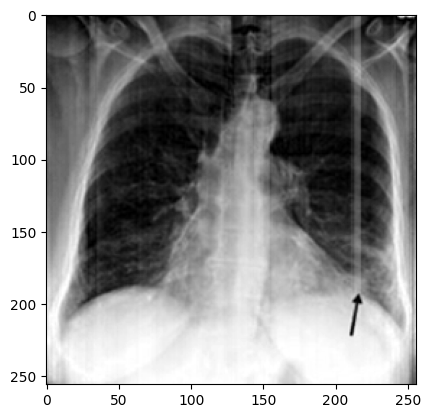

In [83]:
test_1 = test_cd[3][0].squeeze(0)
print(test_1.shape)
plt.imshow(test_1, cmap = 'gray')

In [84]:
print(test_1.unsqueeze(0).shape)

torch.Size([1, 256, 256])


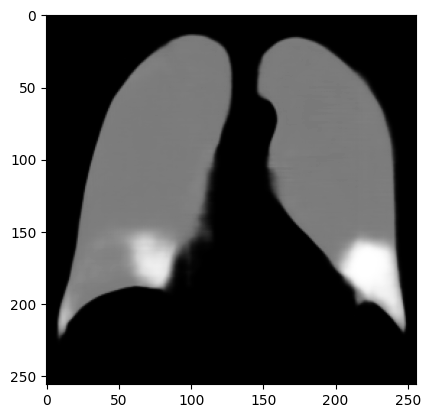

In [85]:
pred_1 = model(test_1.unsqueeze(0).unsqueeze(0).to(device))
plt.imshow(pred_1.detach().cpu().squeeze(), cmap = 'gray')

[0.  0.5 1. ]


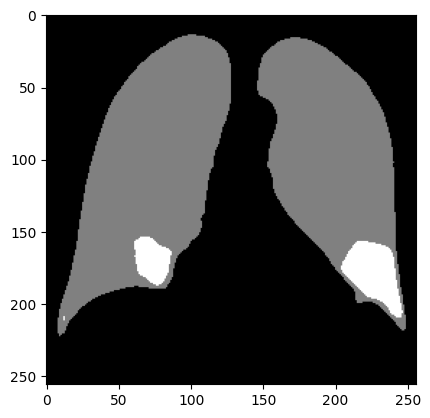

In [86]:
prediction = pred_1.detach().cpu().squeeze()
prediction[prediction < 0.24] = 0
prediction[(prediction >= 0.24) & (prediction < 0.74)] = 0.5
prediction[prediction >= 0.74] = 1
print(np.unique(prediction))
plt.imshow(prediction, cmap= "gray")

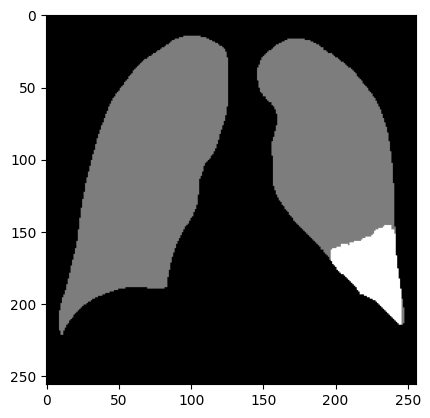

In [87]:
plt.imshow(test_cd[3][1].squeeze(0), cmap = 'gray')

In [65]:
mean_squared_error(test_cd[3][1].squeeze(0),test_1.unsqueeze(0).unsqueeze(0).to(device).detach().cpu().squeeze())

0.35090783